In [150]:
import pandas as pd
import numpy as np
import re
import string

## scipy
import scipy.sparse as ss

## nltk
from nltk import pos_tag
from nltk import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer, WordNetLemmatizer

## gensim
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora

## sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation

## corex
from corextopic import corextopic as ct
from corextopic import vis_topic as vt

## vis
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.sklearn
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [21]:
import warnings
warnings.filterwarnings('ignore')

## Importing Document

In [22]:
file = open('Dune_Books\Dune_1\Dune1.txt','r', encoding = 'utf8')

In [23]:
#text = file.read()
#chapters = text.replace('\n',' ').split('***')

def load_books(num_books = 1):
    books = [open(f'Dune_Books\Dune_{i}\Dune{i}.txt','r', encoding = 'utf8').read() for i in range(1,num_books+1)]
    return books


def split_chapters(corpus):
    book_raw = ' '.join(corpus).split('\n')
    book_chap_lines = []
    chap_index = [idx for idx, line in enumerate(book_raw) if '—' in line and line.isupper()]
    
    for i,index in enumerate(chap_index):
        if i == 0:
            book_chap_lines = [book_raw[0:index]]
        else:
            try:
                book_chap_lines.append(book_raw[index:chap_index[i+1]])
            except:
                pass
        
    book = []
    for chap in book_chap_lines:
        book.append(' '.join(chap))
        
    return book

In [24]:
corpus = load_books(6)
chapters = split_chapters(corpus)
chapters = [chapter for chapter in chapters if len(chapter)>=10000]

In [25]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
stemmer = WordNetLemmatizer()

chap_clean_ = list(map(alphanumeric, chapters))
chap_clean = list(map(punc_lower, chap_clean_))

## Creating Vectorizers

### TF-IDF Vectorizer for LSA and LDA topic modeling

In [26]:
vectorizer = TfidfVectorizer(stop_words = 'english', preprocessor = stemmer.lemmatize)

doc_word = vectorizer.fit_transform(chap_clean)
doc_word.shape

(103, 15266)

In [27]:
chap_idx = [f'Chapter {i}' for i in range(1,104)]
pd.DataFrame(doc_word.toarray(), index = chap_idx, columns = vectorizer.get_feature_names()).head()

,aba,aback,abad,abandon,abandoned,abandonment,abase,abashed,abate,abdicate,...,zeliman,zensunni,zia,ziamad,ziarenka,ziarenko,zigzag,zombie,zone,zones
Chapter 1,0.000000,0.0,0.0,0.005378,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
Chapter 2,0.007283,0.0,0.0,0.006711,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
Chapter 3,0.000000,0.0,0.0,0.000000,0.011081,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01848,0.0
Chapter 4,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
Chapter 5,0.012432,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0


#### Latent Semantic Analysis

In [ ]:
variances = []
for i in range(2,50):
    lsa = TruncatedSVD(i)
    doc_topic = lsa.fit_transform(doc_word) 
    variances.append(np.mean(lsa.explained_variance_ratio_))
plt.figure(figsize=(18,10))
plt.plot(range(2,50), variances)
plt.xlabel('Number of topics')
plt.ylabel('Explained variance ratio'

In [135]:
lsa = TruncatedSVD(20)
doc_topic = lsa.fit_transform(doc_word)
lsa.explained_variance_ratio_

array([0.01155158, 0.07637218, 0.04051027, 0.03769221, 0.03186932,
       0.02637921, 0.02501721, 0.02373563, 0.02259859, 0.02027607,
       0.01990526, 0.01798922, 0.01662683, 0.01622339, 0.01523677,
       0.014829  , 0.0139717 , 0.01320594, 0.01249853, 0.01195605])

,0,1,2,3,4,5,6,7,8,9,...,15256,15257,15258,15259,15260,15261,15262,15263,15264,15265
1,-0.007084,0.002636,-0.000069,-0.006096,-0.008412,-0.00193,-0.001605,0.004571,0.001832,0.001219,...,-0.000769,-0.01063,-0.012625,-0.000069,-0.002399,-0.0008,-0.000767,-0.001143,-0.002883,-0.000357


In [136]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             columns = vectorizer.get_feature_names())
topic_word

,aba,aback,abad,abandon,abandoned,abandonment,abase,abashed,abate,abdicate,...,zeliman,zensunni,zia,ziamad,ziarenka,ziarenko,zigzag,zombie,zone,zones
0,0.004,0.003,0.001,0.005,0.008,0.001,0.001,0.003,0.001,0.001,...,0.000,0.011,0.007,0.001,0.001,0.000,0.001,0.001,0.002,0.000
1,-0.007,0.003,-0.000,-0.006,-0.008,-0.002,-0.002,0.005,0.002,0.001,...,-0.001,-0.011,-0.013,-0.000,-0.002,-0.001,-0.001,-0.001,-0.003,-0.000
2,0.003,-0.000,-0.003,-0.004,-0.003,-0.002,0.004,-0.000,0.003,0.000,...,0.000,0.021,-0.006,-0.003,0.001,0.000,-0.002,0.001,0.002,-0.002
3,0.008,0.002,-0.002,0.004,-0.006,0.002,-0.003,0.002,0.002,0.000,...,0.001,-0.024,0.015,-0.002,0.000,0.000,-0.000,0.001,-0.004,-0.002
4,-0.007,-0.004,0.002,-0.002,0.003,-0.003,-0.001,-0.003,0.000,0.002,...,-0.001,0.005,-0.008,0.002,-0.001,-0.000,-0.001,0.000,-0.002,0.002
5,-0.008,-0.003,0.001,0.002,-0.005,-0.003,0.000,-0.001,-0.001,0.000,...,-0.001,0.009,-0.014,0.001,-0.005,-0.002,-0.001,-0.001,-0.001,-0.000
6,0.013,-0.004,0.002,-0.003,-0.008,-0.007,0.002,0.003,-0.001,0.000,...,0.003,0.001,0.029,0.002,0.007,0.002,-0.002,0.002,0.000,-0.001
7,0.003,0.004,-0.004,0.005,0.002,0.001,-0.000,-0.001,-0.001,-0.004,...,0.001,-0.014,0.009,-0.004,0.004,0.001,-0.001,-0.001,-0.000,0.002
8,0.010,-0.001,-0.002,-0.001,-0.016,0.003,-0.001,0.000,-0.001,0.001,...,0.000,-0.013,-0.007,-0.002,0.000,0.000,0.001,0.001,-0.002,-0.004
9,-0.004,-0.004,-0.004,-0.003,0.009,-0.003,0.001,-0.000,-0.002,0.001,...,-0.001,-0.012,0.014,-0.004,-0.002,-0.001,-0.001,0.000,0.006,-0.001


In [144]:
with open('topics.txt', 'r', encoding = 'utf8') as f:
    tpc_names = [s.strip() for s in f.readlines()]
tpc_names

['Atreides Family',
 'God Emperor Leto II',
 'Paul and life in the desert',
 'House Corrino on Salusa Secundus',
 "God Emperor Leto II's royal party",
 'Farad and the preacher',
 'Paul as the preacher',
 'Topic 7',
 'Topic 8',
 'Topic 9',
 'Topic 10',
 'Topic 11',
 'Topic 12',
 'Topic 13',
 'Topic 14',
 'Topic 15',
 'Topic 16',
 'Topic 17',
 'Topic 18',
 'Topic 19']

In [138]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [147]:
display_topics(lsa, feature_names = vectorizer.get_feature_names(), no_top_words = 10, topic_names= tpc_names)


Topic: ' Atreides Family '
said, leto, idaho, moneo, alia, paul, lord, ghanima, jessica, stilgar

Topic: ' God Emperor Leto II '
moneo, idaho, leto, lord, siona, hwi, fish, speakers, cart, malky

Topic: ' Paul and life in the desert '
idaho, paul, irulan, korba, ghola, scytale, moneo, chani, alia, edric

Topic: ' House Corrino on Salusa Secundus '
farad, jessica, idaho, ghanima, tyekanik, moneo, alia, wensicia, fali, tyek

Topic: ' God Emperor Leto II's royal party '
idaho, siona, nayla, garun, namri, duncan, leto, women, village, sand

Topic: ' Farad and the preacher '
farad, tyekanik, lord, wensicia, paul, said, anteac, scytale, tyek, prince

Topic: ' Paul as the preacher '
preacher, jessica, alia, javid, namri, fali, halleck, leto, lord, anteac

Topic: ' Topic 7 '
siona, nayla, topri, moneo, garun, kobat, tyekanik, tower, farad, preacher

Topic: ' Topic 8 '
anteac, luyseyal, hwi, irulan, lord, nayla, fish, reverend, said, jessica

Topic: ' Topic 9 '
stilgar, lord, preacher, korba, 

In [167]:
text = pd.DataFrame(lsa.components_)[1:2:]
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

TypeError: expected string or bytes-like object

In [145]:
for idx, doc in enumerate(doc_topic):
    topics =[tpc_names[i] for i in doc.argsort()[:3]]
    print(f'Chapter {idx}: {topics}')
    
    

Chapter 0: ['God Emperor Leto II', 'Topic 9', 'Topic 10']
Chapter 1: ['Topic 17', 'Topic 9', 'Topic 15']
Chapter 2: ['Topic 16', 'God Emperor Leto II', 'House Corrino on Salusa Secundus']
Chapter 3: ['Topic 15', 'Topic 17', 'Topic 9']
Chapter 4: ['God Emperor Leto II', "God Emperor Leto II's royal party", 'House Corrino on Salusa Secundus']
Chapter 5: ['House Corrino on Salusa Secundus', 'Topic 12', 'Topic 11']
Chapter 6: ['Topic 16', 'God Emperor Leto II', 'Topic 9']
Chapter 7: ['God Emperor Leto II', 'Topic 13', 'House Corrino on Salusa Secundus']
Chapter 8: ['House Corrino on Salusa Secundus', 'Topic 10', 'God Emperor Leto II']
Chapter 9: ['God Emperor Leto II', 'Topic 13', 'Topic 9']
Chapter 10: ['House Corrino on Salusa Secundus', 'Topic 11', 'Topic 19']
Chapter 11: ['God Emperor Leto II', 'House Corrino on Salusa Secundus', "God Emperor Leto II's royal party"]
Chapter 12: ['House Corrino on Salusa Secundus', 'God Emperor Leto II', 'Topic 18']
Chapter 13: ['Topic 18', 'God Emperor

In [132]:
pd.DataFrame(doc_topic[1:41])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.244523,-0.148740,0.234558,-0.125942,-0.116057,0.169240,-0.150286,-0.017267,0.162549,-0.193035,0.037298,0.270406,0.095426,0.500282,0.082022,-0.171202,0.202265,0.205766,0.026674,0.018032
1,0.404367,-0.245984,0.185273,-0.243107,-0.084298,0.071286,-0.137316,0.059492,-0.008002,-0.148007,0.055747,0.122385,-0.003463,-0.034967,0.120359,0.056208,-0.242897,-0.171248,0.019621,-0.115775
2,0.204882,-0.093809,0.098913,-0.114187,-0.013156,0.125800,-0.075503,0.029055,0.030254,-0.170526,-0.034601,0.099092,0.182725,0.526755,-0.006255,-0.284244,0.273435,0.288994,-0.030447,-0.081482
3,0.432945,-0.316667,0.325830,-0.225955,-0.247201,0.040851,-0.121716,-0.012242,0.058883,0.160628,-0.024741,0.279829,-0.073261,-0.063309,0.083085,0.071496,-0.121181,-0.172373,-0.039074,0.053902
4,0.424034,-0.161622,0.424221,-0.223577,-0.023587,0.128745,-0.030761,-0.135613,0.012202,0.031414,-0.024467,-0.190506,-0.204213,-0.026977,-0.083971,0.102741,0.034367,0.103256,0.029198,-0.007642
5,0.266770,-0.199222,0.152275,-0.061825,-0.160943,0.026278,-0.102517,0.069279,0.200288,-0.165017,0.176516,0.401626,0.004371,-0.011672,0.313452,0.114491,-0.229551,-0.050482,0.303308,-0.026709
6,0.399022,-0.308112,0.172628,-0.122893,-0.116611,-0.120108,0.015284,0.014630,-0.055316,0.260932,-0.091240,0.066065,0.041990,-0.188035,0.007029,-0.031520,0.153631,0.073520,-0.062238,0.117849
7,0.345745,-0.241167,0.350794,-0.294317,-0.174007,0.144341,-0.127052,-0.095982,-0.033581,0.267303,-0.248516,0.071864,-0.076072,0.135974,-0.083448,0.005357,0.056810,-0.061129,-0.182666,0.062383
8,0.454559,-0.196110,0.117183,-0.076032,0.009844,0.005404,0.034126,0.049039,0.046512,-0.153045,0.083306,-0.092464,0.064864,-0.161304,-0.012214,-0.125775,0.227976,0.023527,-0.035864,0.002914
9,0.302541,-0.159339,0.194950,-0.268364,-0.011219,0.088465,-0.009045,0.018260,-0.107193,-0.090226,0.034411,-0.188256,-0.130214,-0.132300,0.023362,0.108278,-0.096259,0.084045,-0.092296,-0.191174


Text(0.5, 0.98, 'Topic Strength by chapter')

<Figure size 1280x800 with 0 Axes>

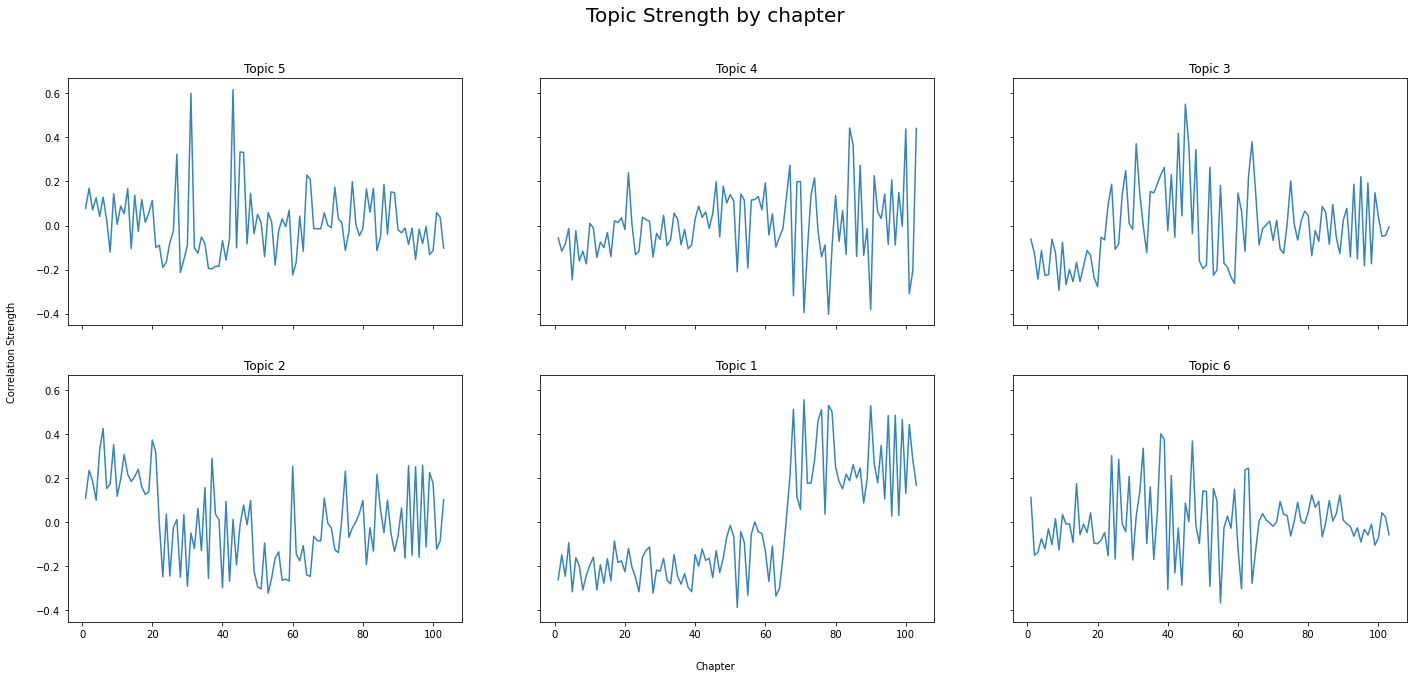

In [130]:
%matplotlib inline

plt.figure(figsize=(16, 10), dpi=80)
fig, axs = plt.subplots(2,3,figsize=(24, 10),sharex=True,sharey=True)
for i in range(1,7):    
    y = doc_topic[:,i]
    x = range(1,104)
    axs[i//3-1,3-i%3-1].plot(x,y, alpha = 0.9)
    axs[i//3-1,3-i%3-1].set_title(f'Topic {i}')

fig.text(0.5, 0.06, 'Chapter', ha='center')
fig.text(0.09, 0.5, 'Correlation Strength', va='center', rotation='vertical')
fig.suptitle('Topic Strength by chapter', fontsize = 20)

#### Latent Dirichlet Analysis

In [ ]:
lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tfidf.fit(doc_word)

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_tfidf, doc_word, vectorizer)

### Count Vectorizer for CorEx modeling

In [ ]:
vectorizer_count = CountVectorizer(stop_words = 'english', preprocessor = stemmer.lemmatize, binary = True)

doc_word_count = vectorizer_count.fit_transform(chap_clean)
doc_word_count.shape

In [ ]:
words = list(np.asarray(vectorizer_count.get_feature_names()))
topic_model = ct.Corex(n_hidden=20, words=words, seed=1)
topic_model.fit(doc_word_count, words=words, docs=chap_clean, 
                anchors = ['water', 'desert','paul','jessica', 'bene','harkonnen', 'atreides','imperial', 'fremen'],
                anchor_strength = 10)

In [ ]:
topic = topic_model.get_topics()
topic

In [ ]:
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

In [ ]:
%matplotlib inline
y = pd.DataFrame(topic_model.p_y_given_x)[0]
x = range(0,139)
plt.plot(x,y)

In [ ]:
pd.DataFrame(topic_model.p_y_given_x)

gensim

In [68]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel


def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for number_of_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

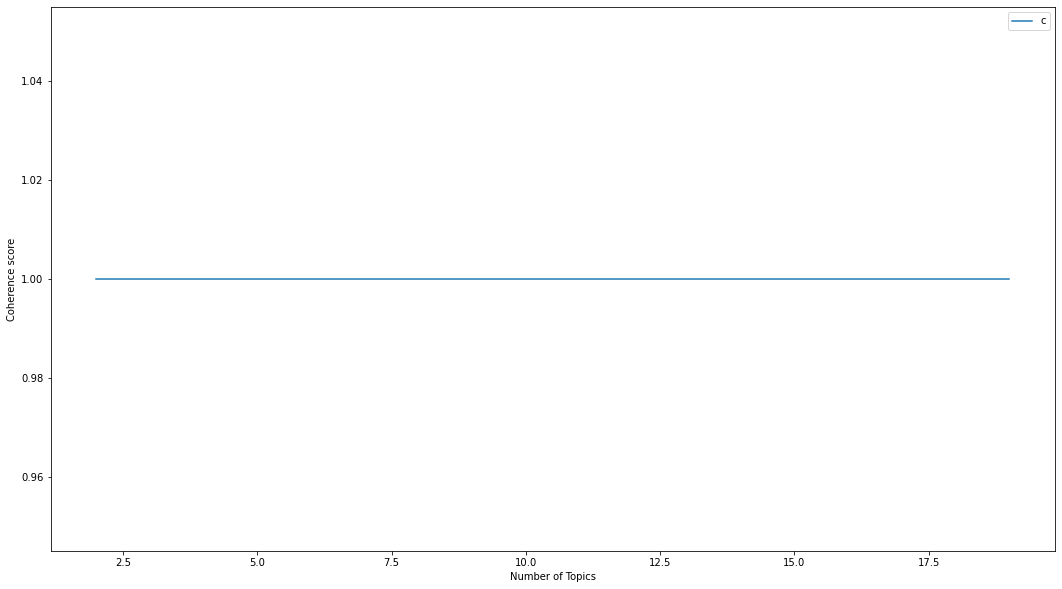

In [87]:
plt.figure(figsize = (18,10))
start,stop,step=2,20,1
plot_graph([chapters],start,stop,step)


In [85]:
dictionary, doc_term_matrix = prepare_corpus([chapters])
        
model = LsiModel(doc_term_matrix, num_topics=8, id2word = dictionary)  # train model
coherencemodel = CoherenceModel(model=model, texts=[chapters], dictionary=dictionary, coherence='c_v')
coherencemodel.get_coherence()

0.9999999999999998

In [66]:
dictionary = corpora.Dictionary([chapters])
dictionary

### preprocessing to do

* split all books into chapters
* lemmatize/stem
* part of speech tagging to create named entity recognition
    * potentially make all multi-word phrases single tokens
* possibly tokenize on n-grams
* cut out quote chapters

### other to do

* topic coherence score
* vis with pyLDAvis
    * word cloud for topics
* streamlet app

### vis to do

* vis topic strength for book 1

In [ ]:
with open('stop_words_english.txt', 'r', encoding = 'utf8') as f:
    stopwords = [s.strip() for s in f.readlines()]
'the' in stopwords

In [ ]:
book2_raw = open(f'Dune_Books\Dune_2\Dune2.txt','r', encoding = 'utf8').read().split('\n')

In [ ]:
book2_raw

In [ ]:
chap_index = [idx for idx, line in enumerate(book2_raw) if '—' in line and line.isupper()]

In [ ]:
for i,index in enumerate(chap_index):
    if i == 0:
        book2_chap_lines = [book2_raw[0:index]]
    else:
        try:
            book2_chap_lines.append(book2_raw[index:chap_index[i+1]])
        except:
            pass

In [ ]:
book2 = []
for chap in book2_chap_lines:
    book2.append(' '.join(chap))


In [ ]:
book2